# Ptychography Reconstruction

This notebook demonstrates a simulated ptychographic reconstruction using tike.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

import tike
import tike.ptycho
import tike.view

In [2]:
for module in [tike, np]:
    print("{} is version {}".format(module.__name__, module.__version__))

tike is version 0.15.2.dev39+g7ca618d.d20210126
numpy is version 1.19.5


## Load test data
This data was simulated using tike and it used for continuous integration testing.

In [3]:
import lzma
import pickle

with lzma.open('../../../tests/data/ptycho_setup.pickle.lzma', 'rb') as file:
    [
        data,
        scan,
        probe,
        original,
    ] = pickle.load(file)

### Define the object
The object consists of two unique views of varying phase: one with constant amplitude and one with varying amplitude.

In [4]:
original.shape

(2, 128, 128)

In [5]:
# Center the phase image in the range (-pi, pi)
original = original * np.exp(-1j * np.pi/2)

(0.001338858+0.9999991j) (1+0.00020559915j)


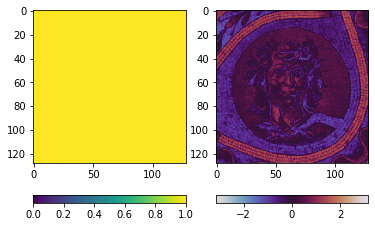

(0.00013624692+5.2331194e-05j) (0.9566685+0.0636505j)


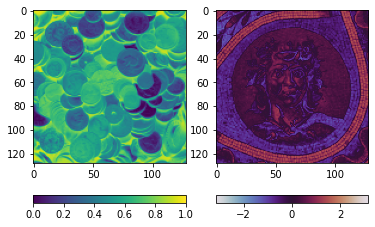

In [6]:
for i in range(len(original)):
    plt.figure()
    tike.view.plot_phase(original[i], amax=1, amin=0)
    plt.show()

### Define the probe

Note that the shape of the probe includes many dimensions. These dimensions are for providing multiple incoherent probes and coherent probbes along with unique probes for multiple dimensions. Read the documentation of the `tike.ptycho.probe` module for more information.

In [7]:
probe.shape

(2, 1, 1, 2, 16, 16)

In [8]:
probe *= 5 # reduce noise

(-3.146963+3.8854375j) (4.9999995+0.0015707964j)


/home/dching/Documents/tike/src/tike/view.py:95: UserWarning: This phase plot will be incorrect because the phase of a zero-amplitude complex number is undefined. Adding a small constant to the amplitude may help.
  "This phase plot will be incorrect because "


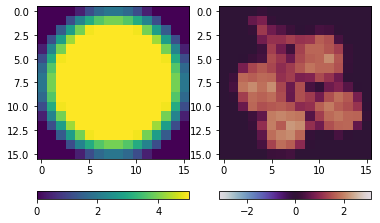

(-2.4711988+0.3783875j) (2.4927204+0.19064504j)


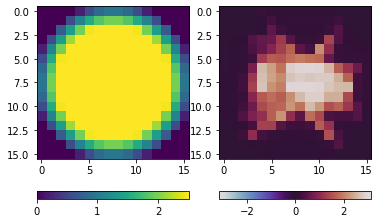

In [9]:
for m in range(probe.shape[-3]):
    plt.figure()
    tike.view.plot_phase(probe[0, 0, 0, m])
    plt.show()

Information about a probe which varies with each scanning position is stored in the `weights` and `coherent_probe` arrays.

In [10]:
# Add some probe variance
np.random.seed(0)
true_coherent_probe = probe
weights = 0.25 * tike.ptycho.probe.simulate_varying_weights(scan, true_coherent_probe)
true_probe = tike.ptycho.probe.get_varying_probe(probe, eigen_probe=true_coherent_probe, weights=weights)

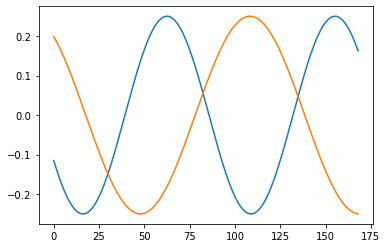

In [11]:
plt.figure()
plt.plot(weights[0, :, 0, 0])
plt.plot(weights[0, :, 0, 1])

### Define the trajectory

Each view may have a different trajectory, but the number of scan positions must be the same. The probe positions that overlap the edge of psi are not allowed.

In [12]:
scan.shape

(2, 169, 2)

In [13]:
# Add some position noise
np.random.seed(0)
true_scan = scan + 1 * (2 * np.random.rand(*scan.shape) - 1)

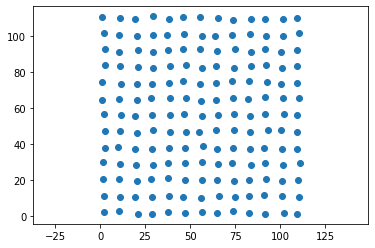

In [14]:
plt.figure()
plt.scatter(true_scan[0, :, 0], true_scan[0, :, 1])
plt.axis('equal')
plt.show()

## Simulate data acquisition

In [15]:
# Then what we see at the detector is the wave propagation
# of the near field wavefront
data = tike.ptycho.simulate(detector_shape=probe.shape[-1] * 2,
                            probe=true_probe, scan=true_scan,
                            psi=original)
data.shape

(2, 169, 32, 32)

In [16]:
np.random.seed(0)
data = np.random.poisson(data)

/home/dching/miniconda3/envs/tike/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


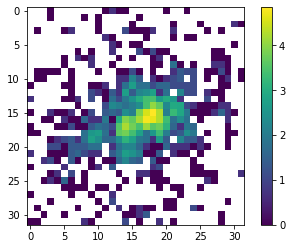

(0, 665)

In [17]:
plt.figure()
plt.imshow(np.fft.fftshift(np.log(data[0, 11])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)

## Reconstruct

Now we need to try and reconstruct psi.

In [18]:
coherent_probe, weights = tike.ptycho.probe.init_varying_probe(scan, probe, 1)

In [19]:
coherent_probe.shape, weights.shape

((2, 1, 1, 2, 16, 16), (2, 169, 1, 2))

In [20]:
# Provide initial guesses for parameters that are updated
np.random.seed(0)
result = {
    'psi': np.ones(original.shape, dtype='complex64'),
    'probe': probe * np.random.rand(*probe.shape),
    'scan': scan,
    'eigen_probe': coherent_probe,
    'eigen_weights': weights,
}

In [21]:
logging.basicConfig(level=logging.INFO)

result = tike.ptycho.reconstruct(
    data=data,
    **result,
    algorithm='lstsq_grad',
    num_iter=128,
    recover_probe=True,
    recover_psi=True,
)

INFO:tike.ptycho.ptycho:lstsq_grad for 169 - 32 by 32 frames for 128 iterations.
INFO:tike.ptycho.ptycho:object and probe rescaled by 1.398572
INFO:tike.ptycho.ptycho:lstsq_grad epoch 0
INFO:tike.ptycho.solvers.divided:  farplane cost is +1.19073e+00
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.97681e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.50995e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +2.50995e+02
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.20571e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.20571e+02
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 1
INFO:tike.ptycho.solvers.divided:  farplane cost is +8.44765e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.11191e-01
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.99078e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.99320e+02
INFO:tike.p

INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 15
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.73992e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +9.34979e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.04758e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.08255e+02
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.05470e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.36366e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 16
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.68378e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +9.20946e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.03331e+02
INFO:tike.ptycho.solvers.divided: nearplane cost is +1.07002e+02
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplan

INFO:tike.ptycho.ptycho:lstsq_grad epoch 30
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.22167e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +8.05417e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.10029e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.69165e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +6.36648e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +6.92377e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 31
INFO:tike.ptycho.solvers.divided:  farplane cost is +3.20121e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +8.00303e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.04296e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.64998e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +6.33606e+01
INFO:tike.ptycho.solvers.divided

INFO:tike.ptycho.solvers.divided:  farplane cost is +2.98840e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +7.47101e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +8.42582e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.25786e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +6.00019e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +6.84812e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 46
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.97689e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +7.44223e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +8.39119e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.24000e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +5.98098e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +6.85121e+01
INFO:tike.p

INFO:tike.ptycho.solvers.divided:  farplane cost is +7.11387e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.98715e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.08711e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +5.75231e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +6.98427e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 61
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.83781e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +7.09453e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.96280e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.08200e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +5.73832e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.00013e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptyc

INFO:tike.ptycho.solvers.divided: nearplane cost is +7.66442e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.07222e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +5.56536e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.31308e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 76
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.73876e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.84691e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.64559e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.07531e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +5.55429e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.34181e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 77
INFO:tike.ptycho.solvers.divided:  farplan

INFO:tike.ptycho.solvers.divided: nearplane cost is +9.15788e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +5.41178e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.82230e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 91
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.66161e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.65402e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.39098e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.16613e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +5.40236e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.86156e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 92
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.65700e-01
INFO:tike.ptycho.solvers.divided:  farplan

INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +5.27828e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +8.46012e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 106
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.59774e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.49434e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +7.17474e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.31672e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +5.26992e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +8.50548e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 107
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.59383e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.48458e-02
INFO:tike.ptycho.solvers.divided: nearpl

INFO:tike.ptycho.solvers.divided: nearplane cost is +5.15997e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.15638e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 121
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.54313e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.35782e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +6.98668e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.49950e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.solvers.divided: nearplane cost is +5.15265e+01
INFO:tike.ptycho.solvers.divided: nearplane cost is +9.20329e+01
INFO:tike.ptycho.solvers.divided:Updating eigen probes
INFO:tike.ptycho.ptycho:lstsq_grad epoch 122
INFO:tike.ptycho.solvers.divided:  farplane cost is +2.53978e-01
INFO:tike.ptycho.solvers.divided:  farplane cost is +6.34944e-02
INFO:tike.ptycho.solvers.divided: nearplane cost is +6.97500e+01
INFO:tike.ptycho.solvers.divid

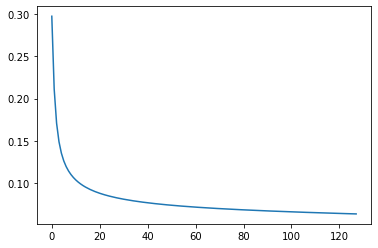

In [22]:
plt.figure()
plt.plot(result['cost'])
plt.show()

(-1.047305+0.17939374j) (3.7618608+0.655712j)
(-2.1428888+3.6436758j) (5.768509+0.8753591j)
(-3.153686+1.3175621j) (3.3205752+0.14948751j)


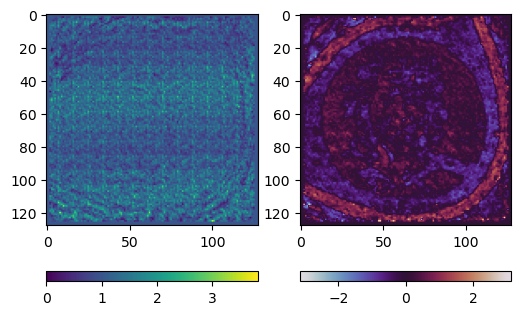

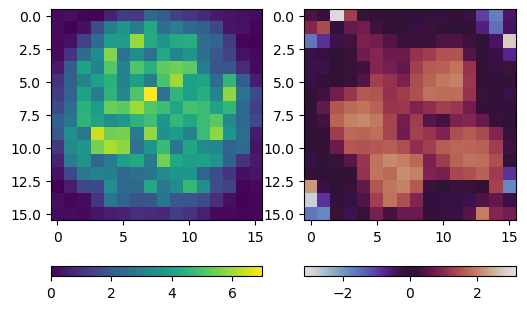

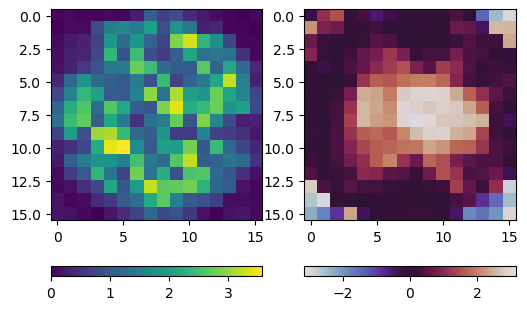

(-0.50873506+1.396821j) (3.1570942-0.3934597j)
(-3.0095506+5.134714j) (6.1496964+1.1832606j)
(-2.9979305+0.55080795j) (3.2052705+0.66596967j)


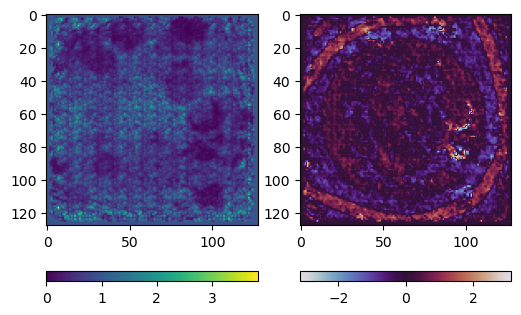

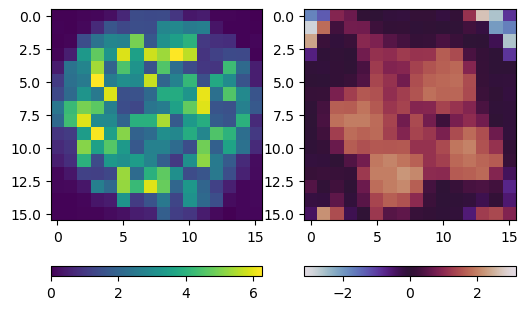

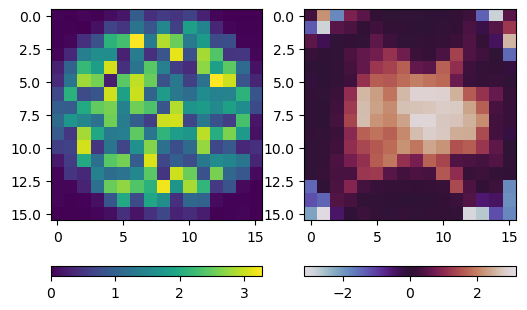

In [23]:
for v in range(len(original)):
    plt.figure(dpi=100)
    tike.view.plot_phase(result['psi'][v], amin=0)
    for m in range(probe.shape[-3]):
        plt.figure(dpi=100)
        tike.view.plot_phase(result['probe'][v, 0, 0, m], amin=0)
    plt.show()